In [1]:
import matplotlib.pyplot as plt
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
# архитектура модели
# гиперпараметры хз
# загрузчик данных
# формирование батча
# инициализировать модель
# оптимизатор
# функция потерь
# опционально шедулеры
# трейн луп

In [3]:
# hyperparams
inp_dim = 28 * 28
hidden = 256
out_dim = 10
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}' # 'cuda:0' id GPU
n_epochs = 10
batch_size = 128

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),
     ])

# зашружаем тренировочный сет
dataset_train = datasets.MNIST('.', 
                               train=True,            
                               download=True, 
                               transform=transform)

dataset_test = datasets.MNIST('.', 
                              train=False,
                              download=True, 
                              transform=transform)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [5]:
dataset_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [6]:
dataset_test

Dataset MNIST
    Number of datapoints: 10000
    Root location: .
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

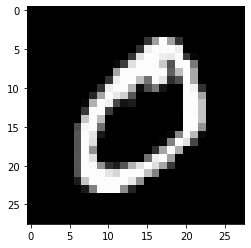

In [7]:
plt.imshow(dataset_train.data[1].detach().numpy(), cmap='gray')
plt.show()

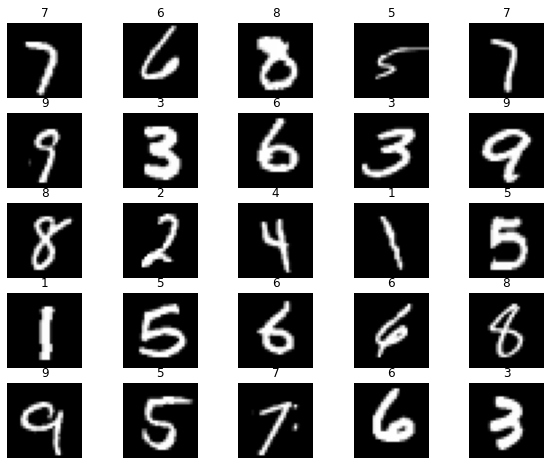

In [9]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
 sample_idx = torch.randint(len(dataset_train), size=(1,)).item()
 img, label = dataset_train[sample_idx]
 figure.add_subplot(rows, cols, i)
 plt.title(label)
 plt.axis("off")
 plt.imshow(img.squeeze(), cmap="gray")
plt.show()

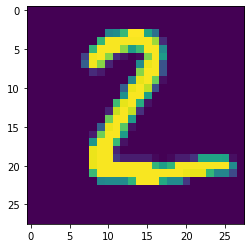

In [8]:
plt.imshow(dataset_test.data[1].detach().numpy())
plt.show()

In [10]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p=0.1):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        # custom init nn.init.xavier_uniform(self.linear1.weight) 
        self.do = nn.Dropout(dropout_p)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        self.activ = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activ(x)
        x = self.do(x)
        x = self.linear2(x)

        return x


In [11]:
# Как формируется батч
# dataloader берет из Samler набор индексов и по этим индексам получает элементы из Dataset
dataset_train = datasets.MNIST('.', train=True, download=True)

def collate_fn(data: list):
    # data = [(pic, target)...]
    pics = []
    targets = []
    for item in data:
        pics.append(numpy.array(item[0]))
        targets.append(item[1])
    pics = torch.from_numpy(numpy.array(pics)).float() / 255
    pics = pics.view(pics.size(0), -1) # mtx 28x28 to vec 7xx
    targets = torch.from_numpy(numpy.array(targets))

    return {
        'data': pics,
        'target': targets,
    }

In [12]:
dataloader_train = DataLoader(dataset_train, 
                        batch_size, 
                        shuffle=True, 
                        collate_fn=collate_fn,
                        drop_last = True,
                        )

In [13]:
dataset_test = datasets.MNIST('.', train=False, download=True)

def collate_fn(data: list):
    # data = [(pic, target)...]
    pics = []
    targets = []
    for item in data:
        pics.append(numpy.array(item[0]))
        targets.append(item[1])
    pics = torch.from_numpy(numpy.array(pics)).float() / 255
    pics = pics.view(pics.size(0), -1) # mtx 28x28 to vec 7xx
    targets = torch.from_numpy(numpy.array(targets))

    return {
        'data': pics,
        'target': targets,
    }

In [ ]:
# 60000 // 128 # число шагов

In [14]:
dataloader_test = DataLoader(dataset_test, 
                        batch_size, 
                        shuffle=True, 
                        collate_fn=collate_fn,
                        drop_last = True,
                        )

In [15]:
model = LinearModel(inp_dim, hidden, out_dim).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

In [16]:
for epoch in range(n_epochs):
    # train model
    model.train()
    for i, batch in enumerate(dataloader_train):
        optim.zero_grad()

        predict = model(batch['data'].to(device))
        loss = loss_func(predict, batch['target'].to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')

    # test model
    model.eval()
    for i, batch in enumerate(dataloader_test):
              inputs, labels = batch
              loss_test = 0
              with torch.no_grad():
                  predict = model(batch['data'].to(device))
                  loss_test += loss_func(predict, batch['target'].to(device))
    print('test loss:', loss_test / i)
    
    #save every epoch
    torch.save(model.state_dict(), f'./chkpt_cv1_{epoch}.pth')

epoch: 0, step: 0, loss: 2.2853968143463135
epoch: 0, step: 200, loss: 0.2616434395313263
epoch: 0, step: 400, loss: 0.145716592669487
test loss: tensor(0.0015)
epoch: 1, step: 0, loss: 0.26671546697616577
epoch: 1, step: 200, loss: 0.08759607374668121
epoch: 1, step: 400, loss: 0.12503257393836975
test loss: tensor(0.0018)
epoch: 2, step: 0, loss: 0.12602663040161133
epoch: 2, step: 200, loss: 0.07422319799661636
epoch: 2, step: 400, loss: 0.08289112150669098
test loss: tensor(0.0021)
epoch: 3, step: 0, loss: 0.07569771260023117
epoch: 3, step: 200, loss: 0.11077646166086197
epoch: 3, step: 400, loss: 0.04930879920721054
test loss: tensor(0.0015)
epoch: 4, step: 0, loss: 0.07244500517845154
epoch: 4, step: 200, loss: 0.07062747329473495
epoch: 4, step: 400, loss: 0.09009288251399994
test loss: tensor(0.0011)
epoch: 5, step: 0, loss: 0.01937379129230976
epoch: 5, step: 200, loss: 0.06694533675909042
epoch: 5, step: 400, loss: 0.09438925236463547
test loss: tensor(0.0023)
epoch: 6, step

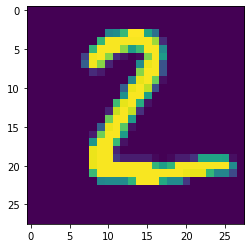

predict: 2
true:    2


In [17]:
i=1
image = dataset_test.data[i].detach().numpy()
data = dataset_test.data[i].unsqueeze(0).view(1, -1).to(device).float()
target = dataset_test.targets[i].tolist()
model.eval()
plt.imshow(image)
plt.show()
predict = torch.argmax(model(data)).squeeze().cpu().detach().tolist()
print(f"predict: {predict}")
print(f"true:    {target}")

In [18]:
class LinearModel1(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p=0.1):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.do1 = nn.Dropout(dropout_p)
        self.act1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.do2 = nn.Dropout(dropout_p)
        self.act2 = nn.ReLU()
        self.linear3 = nn.Linear(hidden_dim // 2, output_dim)

    def forward(self, X):
        X = self.act1(self.do1(self.linear1(X)))
        X = self.act2(self.do2(self.linear2(X)))
        X = self.linear3(X)

        return X
     

In [19]:
model1 = LinearModel1(inp_dim, hidden, out_dim).to(device)
optim = torch.optim.Adam(model1.parameters())
loss_func = nn.CrossEntropyLoss()

In [22]:
for epoch in range(n_epochs):
    # train model
    model1.train()
    for i, batch in enumerate(dataloader_train):
        optim.zero_grad()

        predict = model1(batch['data'].to(device))
        loss = loss_func(predict, batch['target'].to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')

    # test model
    model1.eval()
    for i, batch in enumerate(dataloader_test):
              inputs, labels = batch
              loss_test = 0
              with torch.no_grad():
                  predict = model1(batch['data'].to(device))
                  loss_test += loss_func(predict, batch['target'].to(device))
    print('test loss:', loss_test.item() / i)
    
    #save every epoch
    torch.save(model.state_dict(), f'./chkpt_cv1_{epoch}.pth')

epoch: 0, step: 0, loss: 0.025547949597239494
epoch: 0, step: 200, loss: 0.029750842601060867
epoch: 0, step: 400, loss: 0.028345713391900063
test loss: 0.0011733768435267659
epoch: 1, step: 0, loss: 0.003367712954059243
epoch: 1, step: 200, loss: 0.04249042272567749
epoch: 1, step: 400, loss: 0.04066157713532448
test loss: 0.004402094073109813
epoch: 2, step: 0, loss: 0.026228496804833412
epoch: 2, step: 200, loss: 0.010946211405098438
epoch: 2, step: 400, loss: 0.009774645790457726
test loss: 0.0004081266944284563
epoch: 3, step: 0, loss: 0.01930265501141548
epoch: 3, step: 200, loss: 0.022559301927685738
epoch: 3, step: 400, loss: 0.005721476394683123
test loss: 0.0011480388703284325
epoch: 4, step: 0, loss: 0.008627270348370075
epoch: 4, step: 200, loss: 0.03212476521730423
epoch: 4, step: 400, loss: 0.011340392753481865
test loss: 0.0020089546194324245
epoch: 5, step: 0, loss: 0.014009792357683182
epoch: 5, step: 200, loss: 0.030291419476270676
epoch: 5, step: 400, loss: 0.0096756

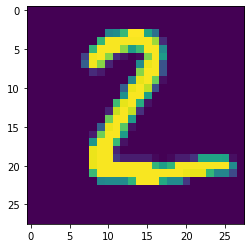

predict: 2
true:    2


In [21]:
i=1
image = dataset_test.data[i].detach().numpy()
data = dataset_test.data[i].unsqueeze(0).view(1, -1).to(device).float()
target = dataset_test.targets[i].tolist()
model1.eval()
plt.imshow(image)
plt.show()
predict = torch.argmax(model1(data)).squeeze().cpu().detach().tolist()
print(f"predict: {predict}")
print(f"true:    {target}")

# Новый раздел

In [23]:
# hyperparams
input_ch = 1
hidden_ch = 128
out_dim = 10
device_id = 0
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128

In [61]:
class ConvDO(nn.Module):
    def __init__(self, input_ch, output_ch, kernel_size, stride, padding, 
                 dropout_p=0.1):
        super().__init__()
        self.conv = nn.Conv2d(
            input_ch, 
            output_ch, 
            kernel_size=kernel_size,
            stride=stride,
            padding=padding, 
        )
        # TODO добавить батч норм
        self.do = nn.Dropout(dropout_p)

    def forward(self, x):

        return self.do(self.conv(x))

class ConvModel(nn.Module):
    def __init__(self, input_ch, hidden_ch, output_dim, dropout_p=0.1):
        super().__init__()
        self.conv1 = ConvDO(input_ch, hidden_ch, 5, 2, 2) # уменьшим размер выходной фичматрицы в 2 раза
        # TODO еще уменьшить размер фичматрицы
        self.conv2 = ConvDO(hidden_ch, hidden_ch, 3, 1, 1)
        # TODO увеличить число выходных каналов
        self.conv3 = ConvDO(hidden_ch, 1, 3, 1, 1)
        self.linear = nn.Linear(
            14 * 14, # TODO поправить при изменении числа каналов и размера фич матриц
            output_dim,
        )  
        self.activ = nn.ReLU()    

    def forward(self, x):
        x = self.activ(self.conv1(x))
        x = self.pool(x)
        x = self.activ(self.conv2(x))
        x = self.activ(self.conv3(x))
        x = self.linear(x.view(x.size(0), -1))

        return x

In [25]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),
     ])

# зашружаем тренировочный сет
dataset_train = datasets.MNIST('.', 
                               train=True,            
                               download=True, 
                               transform=transform)

dataset_test = datasets.MNIST('.', 
                              train=False,
                              download=True, 
                              transform=transform)

In [26]:
trainloader = torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

testloader = torch.utils.data.DataLoader(dataset_test, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

In [27]:
model_conv = ConvModel(input_ch, hidden_ch, out_dim).to(device)
optim = torch.optim.Adam(model_conv.parameters())
loss_func = nn.CrossEntropyLoss()

In [28]:
for epoch in range(n_epochs):
    #train model
    model_conv.train()
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()

        predict = model_conv(inputs.to(device))
        loss = loss_func(predict, labels.to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    
    #test model
    model_conv.eval()
    for i, batch in enumerate(testloader):
        inputs, labels = batch
        loss_test = 0
        with torch.no_grad():
            predict = model_conv(inputs.to(device))
            loss_test += loss_func(predict, labels.to(device))
    
    print('test loss:', loss_test / i)
    
    #save every epoch
    torch.save(model_conv.state_dict(), f'./chkpt_cv1_conv_{epoch}.pth')


epoch: 0, step: 0, loss: 2.2934694290161133
epoch: 0, step: 200, loss: 0.34279605746269226
epoch: 0, step: 400, loss: 0.29226019978523254
test loss: tensor(0.0022, device='cuda:0')
epoch: 1, step: 0, loss: 0.09820900857448578
epoch: 1, step: 200, loss: 0.10948328673839569
epoch: 1, step: 400, loss: 0.16918309032917023
test loss: tensor(0.0014, device='cuda:0')
epoch: 2, step: 0, loss: 0.15241171419620514
epoch: 2, step: 200, loss: 0.08216961473226547
epoch: 2, step: 400, loss: 0.11621838808059692
test loss: tensor(0.0010, device='cuda:0')
epoch: 3, step: 0, loss: 0.04892957583069801
epoch: 3, step: 200, loss: 0.09689443558454514
epoch: 3, step: 400, loss: 0.07678675651550293
test loss: tensor(0.0007, device='cuda:0')
epoch: 4, step: 0, loss: 0.1876034438610077
epoch: 4, step: 200, loss: 0.15658974647521973
epoch: 4, step: 400, loss: 0.057437676936388016
test loss: tensor(0.0007, device='cuda:0')
epoch: 5, step: 0, loss: 0.05136842280626297
epoch: 5, step: 200, loss: 0.07919743657112122

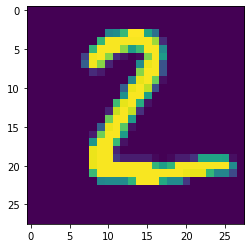

predict: 2
true:    2


In [30]:
i=1
image = dataset_test.data[i].detach().numpy()
data = dataset_test.data[i].unsqueeze(0).unsqueeze(0).to(device).float()
target = dataset_test.targets[i].tolist()
model_conv.eval()
plt.imshow(image)
plt.show()
predict = torch.argmax(model_conv(data)).squeeze().cpu().detach().tolist()
print(f"predict: {predict}")
print(f"true:    {target}")

In [81]:
class ConvModel1(nn.Module):
  def __init__(self, input_ch, hidden_ch, output_dim, dropout_p=0.1):
    super().__init__()
    # уменьшит размер картинки в 2 раза
    
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=3, padding=1, stride=1) 
    self.bn1 = nn.BatchNorm2d(hidden_ch)
    self.pool = nn.MaxPool2d(kernel_size=2) # 14x14
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1, stride=1)
    self.bn2 = nn.BatchNorm2d(hidden_ch)
    self.conv3 = nn.Conv2d(hidden_ch, 5, kernel_size=3, padding=1, stride=1) 
    self.linear1 = nn.Linear(5 * 14 * 14, 100) 
    self.linear2 = nn.Linear(100, output_dim) 
    self.do1 = nn.Dropout(dropout_p)
    self.do2 = nn.Dropout(dropout_p)
    self.activ = nn.ReLU()

  def forward(self, x):
    
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.activ(x)
    x = self.pool(x)
    x = self.do1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.activ(x)
    x = self.do2(x)
    x = self.conv3(x)
    x = self.linear1(x.view(x.size(0), -1))
    x = self.activ(x)
    x = self.linear2(x)
    return x

In [82]:
model_conv1 = ConvModel1(input_ch, hidden_ch, out_dim).to(device)
optim = torch.optim.Adam(model_conv1.parameters())
loss_func = nn.CrossEntropyLoss()

In [83]:
for epoch in range(n_epochs):
    #train model
    model_conv1.train()
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()

        predict = model_conv1(inputs.to(device))
        loss = loss_func(predict, labels.to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    
    #test model
    model_conv1.eval()
    for i, batch in enumerate(testloader):
        inputs, labels = batch
        loss_test = 0
        with torch.no_grad():
            predict = model_conv1(inputs.to(device))
            loss_test += loss_func(predict, labels.to(device))
    
    print('test loss:', loss_test / i)
    
    #save every epoch
    torch.save(model_conv1.state_dict(), f'./chkpt_cv1_conv_{epoch}.pth')

epoch: 0, step: 0, loss: 2.297476291656494
epoch: 0, step: 200, loss: 0.2185956835746765
epoch: 0, step: 400, loss: 0.11441602557897568
test loss: tensor(0.0003, device='cuda:0')
epoch: 1, step: 0, loss: 0.04631646350026131
epoch: 1, step: 200, loss: 0.029902473092079163
epoch: 1, step: 400, loss: 0.005034723784774542
test loss: tensor(0.0004, device='cuda:0')
epoch: 2, step: 0, loss: 0.016138480976223946
epoch: 2, step: 200, loss: 0.07319480180740356
epoch: 2, step: 400, loss: 0.012085361406207085
test loss: tensor(0.0002, device='cuda:0')
epoch: 3, step: 0, loss: 0.02033577859401703
epoch: 3, step: 200, loss: 0.005331458989530802
epoch: 3, step: 400, loss: 0.05097034201025963
test loss: tensor(0.0002, device='cuda:0')
epoch: 4, step: 0, loss: 0.04295724257826805
epoch: 4, step: 200, loss: 0.003983787260949612
epoch: 4, step: 400, loss: 0.005145017057657242
test loss: tensor(0.0001, device='cuda:0')
epoch: 5, step: 0, loss: 0.007256653625518084
epoch: 5, step: 200, loss: 0.05151653662

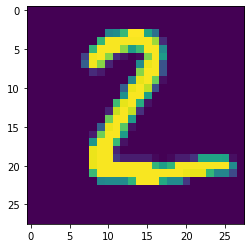

predict: 2
true:    2


In [84]:
i=1
image = dataset_test.data[i].detach().numpy()
data = dataset_test.data[i].unsqueeze(0).unsqueeze(0).to(device).float()
target = dataset_test.targets[i].tolist()
model_conv1.eval()
plt.imshow(image)
plt.show()
predict = torch.argmax(model_conv1(data)).squeeze().cpu().detach().tolist()
print(f"predict: {predict}")
print(f"true:    {target}")